In [125]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad
#import quadpy
from tqdm import tqdm
import time

In [126]:
def Phi1(arr):
    alpha1, alpha2, alpha3, phi1, phi2 = arr
    x1 = np.cos(alpha1) * np.sin(phi1)
    x2 = np.sin(alpha1) * np.sin(phi1)
    x3 = np.sin(alpha2) * np.cos(phi1) * np.sin(phi2)
    x4 = np.cos(alpha2) * np.cos(phi1) * np.sin(phi2)
    x5 = np.sin(alpha3) * np.cos(phi1) * np.cos(phi2)
    x6 = np.cos(alpha3) * np.cos(phi1) * np.cos(phi2)
    return np.array([x1,x2,x3,x4,x5,x6])

def Phi1_inv(x):
    x1, x2, x3, x4, x5, x6 = x
    alpha1 = np.arctan2(x2,x1)
    if alpha1 < 0:
        alpha1 += np.pi
    alpha2 = np.arctan2(x3,x4)
    if alpha2 < 0:
        alpha2 += np.pi
    alpha3 = np.arctan2(x5,x6)
    if alpha3 < 0:
        alpha3 += np.pi
    phi1 = np.arcsin(np.sqrt(x1**2 + x2**2))
    if abs(x1**2 + x2**2 - 1) < 1e-5:
        phi2 = 0
    else:
        phi2 = np.arcsin(np.sqrt((x3**2+x4**2)/(1-x1**2-x2**2)))
    return np.array([alpha1,alpha2,alpha3,phi1,phi2])
    
def Phi(arr):
    x, y, z, t = arr
    alpha = x + 1j*y
    beta = z + 1j*t
    return np.array([[alpha, -beta.conjugate()], [beta,alpha.conjugate()]])

def Phi2(L):
    alpha, phi, U = L
    alpha1, alpha2, alpha3 = alpha
    phi1, phi2 = phi
    arr00 = np.exp(1j*alpha1) * np.cos(phi1)
    arr02 = np.exp(1j*alpha1) * np.sin(phi1)
    arr10 = - np.exp(1j*alpha2) * np.sin(phi1) * np.sin(phi2)
    arr11 = np.exp(-1j*alpha1-1j*alpha3) * np.cos(phi2)
    arr12 = np.exp(1j*alpha2) * np.cos(phi1) * np.sin(phi2)
    arr20 = - np.exp(1j*alpha3) * np.sin(phi1) * np.cos(phi2)
    arr21 = - np.exp(-1j*alpha1-1j*alpha2) * np.sin(phi2)
    arr22 = np.exp(1j*alpha3) * np.cos(phi1) * np.cos(phi2)
    arr0 = np.array([[arr00, 0, arr02],[arr10,arr11,arr12],[arr20,arr21,arr22]])
    arr1 = np.zeros((3,3),dtype=complex)
    arr1[:2,:2] = U
    arr1[2,2] = 1
    return arr0.dot(arr1)

def Phi3(arr):
    x, y = arr[:6], arr[6:]
    arr0 = Phi1_inv(x)
    L = [arr0[:3],arr0[3:],Phi(y)]
    return Phi2(L)

arr0 = np.array([np.pi/4.5,np.pi/3,np.pi/6.5,np.pi/6,np.pi/2.5])
Phi1_inv(Phi1(arr0)), arr0
#Phi(np.array([0,0,1]))

arr = np.array([0,1,0,0,0,0,1,0,0,0])

arr = Phi3(arr)
arr_inv = arr.conjugate().T
arr.dot(arr_inv)

array([[1.00000000e+00+0.j, 0.00000000e+00+0.j, 1.50403894e-49+0.j],
       [0.00000000e+00+0.j, 1.00000000e+00+0.j, 0.00000000e+00+0.j],
       [1.50403894e-49+0.j, 0.00000000e+00+0.j, 1.00000000e+00+0.j]])

In [6]:
def f(p1,p2,p3,p4,p5,t1,t2,t3):
    x1 = np.cos(p1)
    x2 = np.sin(p1) * np.cos(p2)
    x3 = np.sin(p1) * np.sin(p2) * np.cos(p3)
    x4 = np.sin(p1) * np.sin(p2) * np.sin(p3) * np.cos(p4)
    x5 = np.sin(p1) * np.sin(p2) * np.sin(p3) * np.sin(p4) * np.cos(p5)
    x6 = np.sin(p1) * np.sin(p2) * np.sin(p3) * np.sin(p4) * np.sin(p5)
    y1 = np.cos(t1)
    y2 = np.sin(t1) * np.cos(t2)
    y3 = np.sin(t1) * np.sin(t2) * np.cos(t3)
    y4 = np.sin(t1) * np.sin(t2) * np.sin(t3)
    return np.array([x1,x2,x3,x4,x5,x6,y1,y2,y3,y4])

def final(p1,p2,p3,p4,p5,t1,t2,t3):
    return Phi3(f(p1,p2,p3,p4,p5,t1,t2,t3)).trace() * np.sin(p1)**4 * np.sin(p2)**3 * np.sin(p3)**2 * np.sin(p4) * np.sin(t1)**2 * np.sin(t2)

ranges = []
for _ in range(4):
    ranges.append([0,np.pi])
ranges.append([0,2*np.pi])
for _ in range(2):
    ranges.append([0,np.pi])
ranges.append([0,2*np.pi])

#nquad(final,ranges)

In [127]:
# SU(2)

def diffeo(t1,t2,t3):
    x1 = np.cos(t1)
    x2 = np.sin(t1) * np.cos(t2)
    x3 = np.sin(t1) * np.sin(t2) * np.cos(t3)
    x4 = np.sin(t1) * np.sin(t2) * np.sin(t3)
    arr = np.array([x1,x2,x3,x4])
    return Phi(arr)

def su_integrand(U):
    Udag = U.conjugate().transpose()
    return U[0,1] * Udag[1,0]

def integrand(t1,t2,t3):
    return np.real(1/(2*np.pi**2)*su_integrand(diffeo(t1,t2,t3)) * np.sin(t1)**2 * np.sin(t2))

nquad(integrand,[[0,np.pi],[0,np.pi],[0,2*np.pi]])

# Yang-Mills in 1 + 1 dim is (probably) trivial (representation matrix element orthogonality, check calculations)

(0.5, 7.301570405045896e-12)

In [139]:
def char(n,t1,t2,t3):
    if t1 != 0:
        return np.sin((n+1) * t1)/np.sin(t1)
    else:
        return n+1

def fourier(f,n,param):
    def integrand(t1,t2,t3):
        return 1/(2*np.pi**2) * f(diffeo(t1,t2,t3)) * char(n,t1,t2,t3) * np.sin(t1)**2 * np.sin(t2)
    return nquad(integrand,[[0,np.pi],[0,np.pi],[0,2*np.pi]])[0]

def f(U,param):
    return np.exp(2*param*np.real(U.trace()))

def Z(param,L):
    s = 0
    for n in range(4):
        s += (np.exp(-4*param)/(n+1) * fourier(lambda U:f(U,param),n,param))**(L**2)
    return s

#fourier(f,10,1)

#Z(1,10)

def convergence(param,L,n):
    return fourier(lambda U:f(U,param),n,param)**(L**2) * (n+1)**(10**2)

#convergence(1,10,6)

#Z(10,10)

In [130]:
temps = np.linspace(1,300,100)
Z_vec = np.vectorize(lambda param:Z(param,10))

Z_list = []

# Create an iterable (e.g., a list or range)
my_list = range(len(temps))

# Wrap the iterable with tqdm
for item in tqdm(my_list):
    # Simulate some processing time
    time.sleep(0.1)
    
    Z_list.append(Z(1/temps[item],10))
    
    # This code will be executed for each item in the iterable


  0%|                                                   | 0/100 [00:06<?, ?it/s]


KeyboardInterrupt: 

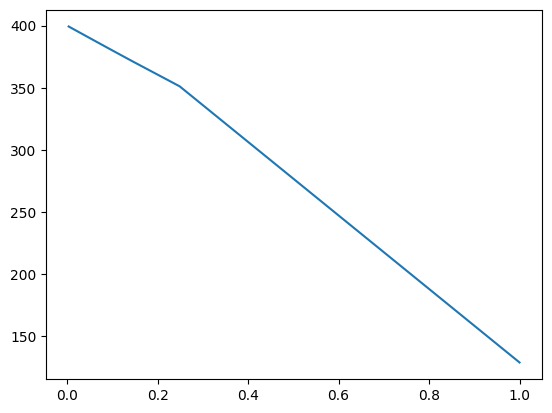

In [51]:
Z_arr = np.array(Z_list)

plt.plot(1/temps[::-1],-temps[::-1]*np.log(Z_arr[::-1]))

In [142]:
betas = np.linspace(0,0.5,100)
#Z_vec = np.vectorize(lambda param:Z(param,10))

Z_list1 = []

# Create an iterable (e.g., a list or range)
my_list = range(len(betas))

# Wrap the iterable with tqdm
for item in tqdm(my_list):
    # Simulate some processing time
    #time.sleep(0.1)
    
    Z_list1.append(Z(betas[item],10))
    
    # This code will be executed for each item in the iterable


100%|█████████████████████████████████████████| 100/100 [04:32<00:00,  2.73s/it]


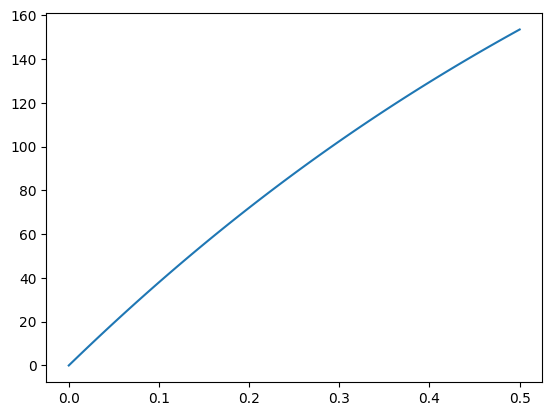

/var/folders/c7/_nlmffn91z9864jmkznb7mx9hx_pfj/T/ipykernel_21810/1747692995.py:8: RuntimeWarning: divide by zero encountered in divide
  free = - 1/betas * np.log(Z_arr1)


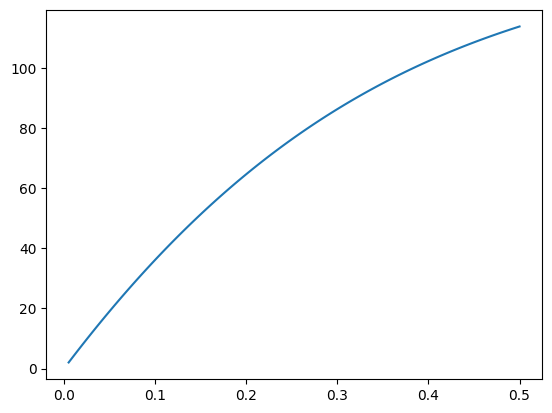

In [143]:
Z_arr1 = np.array(Z_list1)

plt.plot(betas,-np.log(Z_arr1))
plt.show()

energy = - betas[1::] * np.diff(np.log(Z_arr1))/np.diff(betas)
capacity = -betas[2::]**2 * np.diff(energy)/np.diff(betas[1::])
free = - 1/betas * np.log(Z_arr1)
pressure = - np.diff(free)/np.diff(betas)

plt.plot(betas[1::],energy)
plt.show()

#plt.plot(betas[2::],capacity)
#plt.show()

#plt.plot(betas,free)
#plt.show()

#plt.plot(betas[1::],pressure)
#plt.show()

#density = energy/betas[1::]**3
#temperature = 1/betas[1::]
#temperature = temperature[::-1]

#plt.plot(temperature,density[::-1])
#plt.show()

In [60]:
Z(3,10)

OverflowError: (34, 'Result too large')